In [109]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [110]:
"""
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68', 'Mass_u68',
        'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flux_corr',
       'g_hsc_flux_corr', 'nb921_hsc_flux_corr', 'g_rcs_flux_corr'
]
"""
"""
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 
        'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flux_corr',
       'g_hsc_flux_corr', 'nb921_hsc_flux_corr', 'g_rcs_flux_corr'
]
"""
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 'r_rcs_flux_corr',
       'g_flux_corr', 'nb921_hsc_flux_corr'
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [111]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_filled_preprocessed.csv")

In [112]:
data.columns

Index(['Source_Name', 'Total_flux', 'Peak_flux', 'S_Code', 'EBV',
       'FUV_flux_corr', 'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr',
       'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr',
       'y_flux_corr', 'J_flux_corr', 'H_flux_corr', 'K_flux_corr',
       'Ks_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250',
       'F_SPIRE_350', 'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68',
       'Mass_u68', 'Source', 'AGN_final', 'RadioAGN_final', 'Classification',
       'Radio_excess', 'AGNfrac_af', 'AGNfrac_af_16', 'AGNfrac_cg_s_16',
       'Xray', 'Opt_spec', 'IRAGN', 'Extended_radio', 'z_rcs_flux_corr',
       'z_hsc_flux_corr', 'i_hsc_flux_corr', 'i_rcs_flux_corr', 'i_flux_corr',
       'y_hsc_flux_corr', 'r_flux_corr', 'r_hsc_flux_corr', 'r_rcs_flux_corr',
       'ch1_swire_flux_corr', 'ch2_swire_flux_corr', 'ch3_swire_flux_corr',
       'ch4_swire_flux_corr', 'ch1_

In [113]:
data.isna().sum()

Source_Name            0
Total_flux             0
Peak_flux              0
S_Code                 0
EBV                    0
                      ..
ch2_servs_flux_corr    0
g_flux_corr            0
g_hsc_flux_corr        0
nb921_hsc_flux_corr    0
g_rcs_flux_corr        0
Length: 63, dtype: int64

In [114]:
X = data[features_num]
y = data[np.append(y_column, ['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN'])]

In [115]:
le = LabelEncoder()
labels = np.unique(y[y_column].astype(str))
y[y_column] = le.fit_transform(y[y_column])

/var/lib/condor/execute/dir_442968/ipykernel_443786/2925652128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y_column] = le.fit_transform(y[y_column])


In [116]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

y_train_flags = y_train[['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN']]
y_test_flags = y_test[['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN']]

y_train = y_train.drop(columns=['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN'])
y_test = y_test.drop(columns=['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN'])

In [117]:
def one_hot(df, columns):
    """
    One-hot encoding a certain column in a dataframe
    """
    one_hot = pd.get_dummies(df[columns])
    df = df.drop(columns=columns, axis = 1)
    df = df.join(one_hot)
    return df

In [118]:
# Standard scaling the numerical data
scaler = MinMaxScaler()

# Transforming the categorical data
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

In [119]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Random forest

In [221]:
clf = RandomForestClassifier(n_estimators=200, 
                             max_features=None,
                             n_jobs=-1, 
                             class_weight={0: 3, 1: 1000, 2: 1.5, 3: 0.5},
                             random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 3, 1: 1000, 2: 1.5, 3: 0.5},
                       max_features=None, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [195]:
cv_score = cross_val_score(clf, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [196]:
print("Cross-validated Accuracy:", round(np.mean(cv_score), 5), "±", round(np.std(cv_score), 5))

Cross-validated Accuracy: 0.83311 ± 0.01399


In [222]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8109    0.5498    0.6553      2581
quasar-like radio AGN / high-excitation radio galaxy     0.4828    0.1556    0.2353       270
                                     radio-quiet AGN     0.7609    0.5140    0.6136      1356
                                 star-forming galaxy     0.8531    0.9627    0.9046     11315

                                            accuracy                         0.8408     15522
                                           macro avg     0.7269    0.5455    0.6022     15522
                                        weighted avg     0.8316    0.8408    0.8261     15522



[]

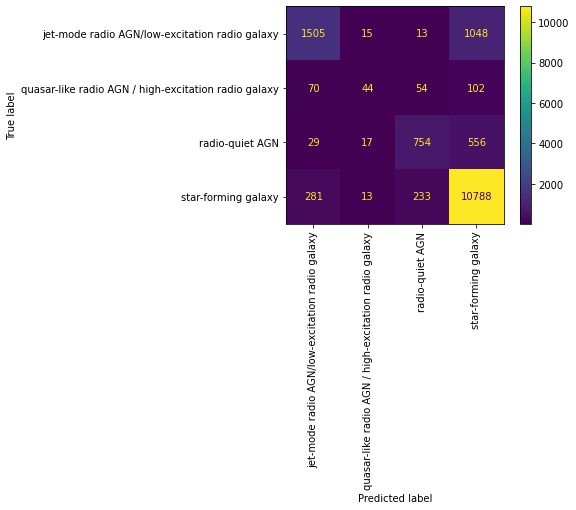

In [77]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# Lightgbm

In [79]:
import lightgbm as lgb
lightbm = lgb.LGBMClassifier(num_class=4, 
                             objective="multiclass",  
                             n_estimators=10000, 
                             class_weight="balanced",
                            early_stopping_round=50,
                             eta=0.3,
                            #verbose=-1,
                            max_depth=9,
                            num_leaves=400
                            #min_data_in_leaf=0
                            )

ModuleNotFoundError: No module named 'lightgbm'

In [80]:
2**6

64

In [151]:
lightbm.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], sample_weight=classes_weights)

d:\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[1]	training's multi_logloss: 0.598529	valid_0's multi_logloss: 2.21117
[2]	training's multi_logloss: 0.511171	valid_0's multi_logloss: 1.97029
[3]	training's multi_logloss: 0.447387	valid_0's multi_logloss: 1.80528
[4]	training's multi_logloss: 0.395546	valid_0's multi_logloss: 1.67328
[5]	training's multi_logloss: 0.352844	valid_0's multi_logloss: 1.57497
[6]	training's multi_logloss: 0.317932	valid_0's multi_logloss: 1.49091
[7]	training's multi_logloss: 0.286716	valid_0's multi_logloss: 1.41857
[8]	training's multi_logloss: 0.260546	valid_0's multi_logloss: 1.35829
[9]	training's multi_logloss: 0.237289	valid_0's multi_logloss: 1.30468
[10]	training's multi_logloss: 0.217451	valid_0's multi_logloss: 1.26338
[11]	training's multi_logloss: 0.201334	valid_0's multi_logloss: 1.22388
[12]	training's multi_logloss: 0.18616	valid_0's multi_logloss: 1.18907
[13]	training's multi_logloss

[110]	training's multi_logloss: 0.0104751	valid_0's multi_logloss: 0.443404
[111]	training's multi_logloss: 0.010318	valid_0's multi_logloss: 0.441821
[112]	training's multi_logloss: 0.0101923	valid_0's multi_logloss: 0.440681
[113]	training's multi_logloss: 0.00998949	valid_0's multi_logloss: 0.438478
[114]	training's multi_logloss: 0.00977781	valid_0's multi_logloss: 0.436125
[115]	training's multi_logloss: 0.00959928	valid_0's multi_logloss: 0.434548
[116]	training's multi_logloss: 0.00946923	valid_0's multi_logloss: 0.43384
[117]	training's multi_logloss: 0.00929979	valid_0's multi_logloss: 0.431968
[118]	training's multi_logloss: 0.0091208	valid_0's multi_logloss: 0.430183
[119]	training's multi_logloss: 0.0089441	valid_0's multi_logloss: 0.42837
[120]	training's multi_logloss: 0.00881349	valid_0's multi_logloss: 0.427176
[121]	training's multi_logloss: 0.00867635	valid_0's multi_logloss: 0.425463
[122]	training's multi_logloss: 0.00856022	valid_0's multi_logloss: 0.424557
[123]	t

[218]	training's multi_logloss: 0.0021975	valid_0's multi_logloss: 0.362107
[219]	training's multi_logloss: 0.00216491	valid_0's multi_logloss: 0.361856
[220]	training's multi_logloss: 0.00213802	valid_0's multi_logloss: 0.361576
[221]	training's multi_logloss: 0.00210997	valid_0's multi_logloss: 0.361516
[222]	training's multi_logloss: 0.00208012	valid_0's multi_logloss: 0.361298
[223]	training's multi_logloss: 0.00205825	valid_0's multi_logloss: 0.361256
[224]	training's multi_logloss: 0.00203144	valid_0's multi_logloss: 0.361169
[225]	training's multi_logloss: 0.00200326	valid_0's multi_logloss: 0.360908
[226]	training's multi_logloss: 0.0019753	valid_0's multi_logloss: 0.360736
[227]	training's multi_logloss: 0.00195796	valid_0's multi_logloss: 0.36066
[228]	training's multi_logloss: 0.00191552	valid_0's multi_logloss: 0.360183
[229]	training's multi_logloss: 0.00189651	valid_0's multi_logloss: 0.360087
[230]	training's multi_logloss: 0.00188	valid_0's multi_logloss: 0.359991
[231]

[327]	training's multi_logloss: 0.000491224	valid_0's multi_logloss: 0.361564
[328]	training's multi_logloss: 0.000485137	valid_0's multi_logloss: 0.361733
[329]	training's multi_logloss: 0.000477417	valid_0's multi_logloss: 0.361745
[330]	training's multi_logloss: 0.000469415	valid_0's multi_logloss: 0.361808
[331]	training's multi_logloss: 0.000464373	valid_0's multi_logloss: 0.36207
[332]	training's multi_logloss: 0.000457262	valid_0's multi_logloss: 0.362225
[333]	training's multi_logloss: 0.000450959	valid_0's multi_logloss: 0.362537
[334]	training's multi_logloss: 0.000445419	valid_0's multi_logloss: 0.36283
[335]	training's multi_logloss: 0.000440238	valid_0's multi_logloss: 0.362969


LGBMClassifier(class_weight='balanced', early_stopping_round=50, eta=0.3,
               max_depth=9, n_estimators=10000, num_class=4, num_leaves=400,
               objective='multiclass')

In [231]:
cv_score_lgb = cross_val_score(lightbm, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [232]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_lgb), 5), "±", round(np.std(cv_score_lgb), 5))

Cross-validated Accuracy: 0.87436 ± 0.01571


In [152]:
y_pred = lightbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7888    0.8566    0.8213      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5402    0.4481    0.4899       270
                                     radio-quiet AGN     0.6850    0.8068    0.7409      1356
                                 star-forming galaxy     0.9497    0.9147    0.9319     11315

                                            accuracy                         0.8875     15522
                                           macro avg     0.7409    0.7566    0.7460     15522
                                        weighted avg     0.8927    0.8875    0.8891     15522



[]

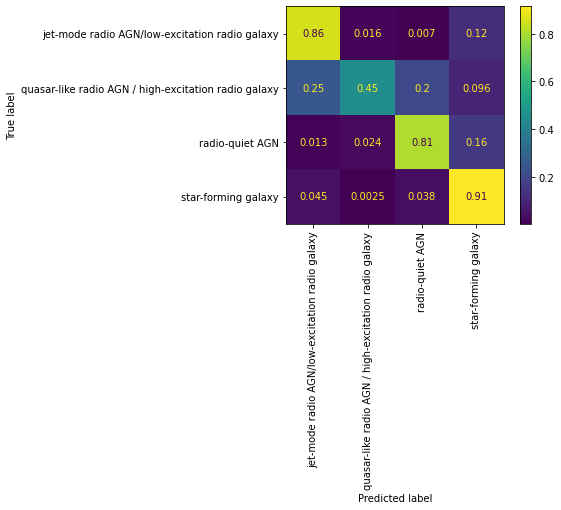

In [160]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [174]:
y_pred_xgb = model.predict(X_test)
y_pred_lgb = lightbm.predict(X_test)

In [175]:
y_pred_temp = y_pred_xgb.copy()
y_pred_temp[y_pred_temp==0] = 0
y_pred_temp[y_pred_lgb==0] = 0

In [176]:
print(classification_report(y_test, y_pred_temp, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7663    0.8842    0.8210      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5628    0.4148    0.4776       270
                                     radio-quiet AGN     0.7199    0.7942    0.7553      1356
                                 star-forming galaxy     0.9537    0.9144    0.9337     11315

                                            accuracy                         0.8902     15522
                                           macro avg     0.7507    0.7519    0.7469     15522
                                        weighted avg     0.8953    0.8902    0.8914     15522



# XGBoost

In [120]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=9, 
                      reg_alpha=0.5, 
                      min_child_weight=3, 
                      reg_lambda=3,
                      eta=0.1, # Remember to reduce to 0.1 or 0.05 for better results
                      tree_method='hist', # exact is more precies, but this is much faster
                      objective='multi:softprob',
                      n_estimators=8000,
                      )

In [121]:
bst = model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_test, y_test)], 
                early_stopping_rounds=50,
                verbose=True, 
                sample_weight=classes_weights
               ) # Maybe remove weight

/Users/users/karsten/.local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.27511	validation_1-mlogloss:1.27926
[1]	validation_0-mlogloss:1.18256	validation_1-mlogloss:1.19026
[2]	validation_0-mlogloss:1.10374	validation_1-mlogloss:1.11545
[3]	validation_0-mlogloss:1.03493	validation_1-mlogloss:1.05016
[4]	validation_0-mlogloss:0.97405	validation_1-mlogloss:0.99229
[5]	validation_0-mlogloss:0.92086	validation_1-mlogloss:0.94190
[6]	validation_0-mlogloss:0.87335	validation_1-mlogloss:0.89710
[7]	validation_0-mlogloss:0.82979	validation_1-mlogloss:0.85617
[8]	validation_0-mlogloss:0.79069	validation_1-mlogloss:0.81956
[9]	validation_0-mlogloss:0.75540	validation_1-mlogloss:0.78679
[10]	validation_0-mlogloss:0.72312	validation_1-mlogloss:0.75702
[11]	validation_0-mlogloss:0.69403	validation_1-mlogloss:0.73015
[12]	validation_0-mlogloss:0.66750	validation_1-mlogloss:0.70563
[13]	validation_0-mlogloss:0.64331	validation_1-mlogloss:0.68347
[14]	validation_0-mlogloss:0.62148	validation_1-mlogloss:0.66359
[15]	validation_0-mlogloss:0.60105	

[126]	validation_0-mlogloss:0.17495	validation_1-mlogloss:0.32027
[127]	validation_0-mlogloss:0.17412	validation_1-mlogloss:0.31987
[128]	validation_0-mlogloss:0.17264	validation_1-mlogloss:0.31908
[129]	validation_0-mlogloss:0.17123	validation_1-mlogloss:0.31839
[130]	validation_0-mlogloss:0.17038	validation_1-mlogloss:0.31799
[131]	validation_0-mlogloss:0.16952	validation_1-mlogloss:0.31761
[132]	validation_0-mlogloss:0.16868	validation_1-mlogloss:0.31720
[133]	validation_0-mlogloss:0.16710	validation_1-mlogloss:0.31644
[134]	validation_0-mlogloss:0.16606	validation_1-mlogloss:0.31597
[135]	validation_0-mlogloss:0.16468	validation_1-mlogloss:0.31517
[136]	validation_0-mlogloss:0.16403	validation_1-mlogloss:0.31488
[137]	validation_0-mlogloss:0.16302	validation_1-mlogloss:0.31444
[138]	validation_0-mlogloss:0.16230	validation_1-mlogloss:0.31408
[139]	validation_0-mlogloss:0.16154	validation_1-mlogloss:0.31378
[140]	validation_0-mlogloss:0.16056	validation_1-mlogloss:0.31339
[141]	vali

[251]	validation_0-mlogloss:0.08901	validation_1-mlogloss:0.28542
[252]	validation_0-mlogloss:0.08849	validation_1-mlogloss:0.28525
[253]	validation_0-mlogloss:0.08807	validation_1-mlogloss:0.28516
[254]	validation_0-mlogloss:0.08772	validation_1-mlogloss:0.28506
[255]	validation_0-mlogloss:0.08731	validation_1-mlogloss:0.28505
[256]	validation_0-mlogloss:0.08677	validation_1-mlogloss:0.28487
[257]	validation_0-mlogloss:0.08632	validation_1-mlogloss:0.28471
[258]	validation_0-mlogloss:0.08596	validation_1-mlogloss:0.28457
[259]	validation_0-mlogloss:0.08551	validation_1-mlogloss:0.28444
[260]	validation_0-mlogloss:0.08513	validation_1-mlogloss:0.28433
[261]	validation_0-mlogloss:0.08476	validation_1-mlogloss:0.28422
[262]	validation_0-mlogloss:0.08441	validation_1-mlogloss:0.28414
[263]	validation_0-mlogloss:0.08406	validation_1-mlogloss:0.28404
[264]	validation_0-mlogloss:0.08371	validation_1-mlogloss:0.28400
[265]	validation_0-mlogloss:0.08321	validation_1-mlogloss:0.28392
[266]	vali

[376]	validation_0-mlogloss:0.05236	validation_1-mlogloss:0.27879
[377]	validation_0-mlogloss:0.05215	validation_1-mlogloss:0.27878
[378]	validation_0-mlogloss:0.05191	validation_1-mlogloss:0.27871
[379]	validation_0-mlogloss:0.05175	validation_1-mlogloss:0.27870
[380]	validation_0-mlogloss:0.05158	validation_1-mlogloss:0.27873
[381]	validation_0-mlogloss:0.05136	validation_1-mlogloss:0.27868
[382]	validation_0-mlogloss:0.05112	validation_1-mlogloss:0.27861
[383]	validation_0-mlogloss:0.05091	validation_1-mlogloss:0.27858
[384]	validation_0-mlogloss:0.05066	validation_1-mlogloss:0.27850
[385]	validation_0-mlogloss:0.05043	validation_1-mlogloss:0.27842
[386]	validation_0-mlogloss:0.05026	validation_1-mlogloss:0.27841
[387]	validation_0-mlogloss:0.05007	validation_1-mlogloss:0.27845
[388]	validation_0-mlogloss:0.04993	validation_1-mlogloss:0.27849
[389]	validation_0-mlogloss:0.04972	validation_1-mlogloss:0.27845
[390]	validation_0-mlogloss:0.04947	validation_1-mlogloss:0.27845
[391]	vali

In [27]:
bst.save_model('combined_xgboost.json')

[]

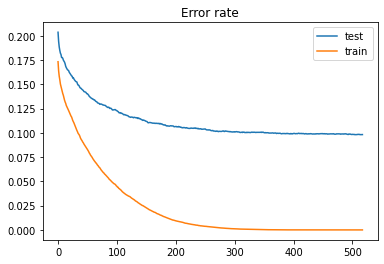

In [297]:
errors_test = bst.evals_result()['validation_0']['merror']
plt.plot(range(len(errors_test)), errors_test, label='test')
errors_train = bst.evals_result()['validation_1']['merror']
plt.plot(range(len(errors_train)), errors_train, label='train')
plt.title('Error rate')
plt.legend()
plt.plot()

[]

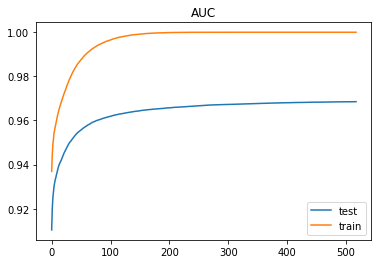

In [298]:
errors_test = bst.evals_result()['validation_0']['auc']
plt.plot(range(len(errors_test)), errors_test, label='test')
errors_train = bst.evals_result()['validation_1']['auc']
plt.plot(range(len(errors_train)), errors_train, label='train')
plt.title('AUC')
plt.legend()
plt.plot()

In [28]:
2**13

8192

In [122]:
cross_val_model = XGBClassifier(use_label_encoder=False, 
                      max_depth=9, 
                      reg_alpha=0.5, 
                      min_child_weight=3, 
                      reg_lambda=3,
                      eta=0.1,
                      tree_method='hist', # exact is more precies, but this is much faster
                      objective='multi:softprob',
                      n_estimators=800,
                      )

In [123]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=512)

cv_score_xgb = cross_val_score(cross_val_model, X_train, y_train, cv=skf, n_jobs=64, scoring="accuracy")

In [124]:
print(cv_score_xgb)

[0.93442623 0.90163934 0.8852459  0.90163934 0.81967213 0.86065574
 0.92622951 0.92622951 0.91803279 0.89344262 0.8852459  0.8852459
 0.91803279 0.93442623 0.91803279 0.86065574 0.90163934 0.93442623
 0.90163934 0.90163934 0.87704918 0.86885246 0.93442623 0.92622951
 0.90163934 0.90983607 0.87704918 0.8852459  0.89344262 0.87704918
 0.90983607 0.90163934 0.92622951 0.90163934 0.91803279 0.8852459
 0.90983607 0.89344262 0.8852459  0.86885246 0.90163934 0.85245902
 0.90983607 0.8852459  0.86065574 0.90983607 0.90163934 0.91803279
 0.89344262 0.86885246 0.93442623 0.92622951 0.91803279 0.90163934
 0.91803279 0.89344262 0.90983607 0.81967213 0.92622951 0.93442623
 0.90983607 0.95081967 0.91803279 0.92622951 0.86065574 0.94262295
 0.90983607 0.91803279 0.90983607 0.91803279 0.87704918 0.90163934
 0.87704918 0.91803279 0.86885246 0.91803279 0.86065574 0.8852459
 0.89344262 0.89344262 0.83606557 0.8442623  0.91803279 0.8852459
 0.92622951 0.94262295 0.90983607 0.90163934 0.92622951 0.87704918

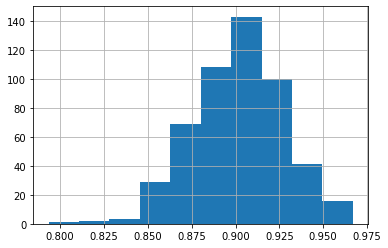

In [125]:
plt.hist(cv_score_xgb, bins=10)
plt.grid()

In [126]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

Cross-validated Accuracy: 0.90089 ± 0.02438


Cross-validated Accuracy: 0.90071 ± 0.0243

In [127]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8186    0.8442    0.8312      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5701    0.4519    0.5041       270
                                     radio-quiet AGN     0.7197    0.8046    0.7597      1356
                                 star-forming galaxy     0.9465    0.9310    0.9387     11315

                                            accuracy                         0.8972     15522
                                           macro avg     0.7637    0.7579    0.7584     15522
                                        weighted avg     0.8988    0.8972    0.8976     15522



In [106]:
y_train.value_counts()

Classification
3                 45325
0                 10186
2                  5514
1                  1062
dtype: int64

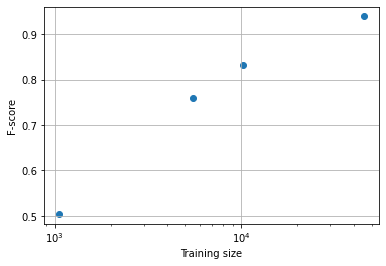

In [180]:
class_sizes = np.array([10186, 1062, 5514, 45325])
F_scores = np.array([0.8312, 0.5041, 0.7597, 0.9387])
plt.scatter(class_sizes, F_scores)
plt.xlabel("Training size")
plt.ylabel("F-score")
plt.grid()
plt.xscale("log")
plt.savefig("Sample_sizes.pdf")

/var/lib/condor/execute/dir_442968/ipykernel_443786/4113404208.py:2: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)


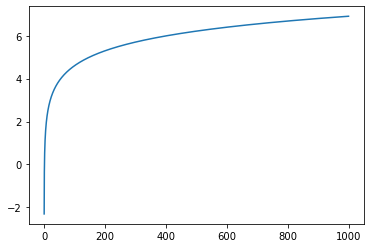

In [170]:
x = np.linspace(0,1000,10**4)
y = np.log(x)
plt.plot(x,y)

In [16]:
test = [0.99 for i in range(99)]
test.append(0.01)
print("Data:", round(np.mean(test), 5), "±", round(np.std(test), 5))

Data: 0.9802 ± 0.09751


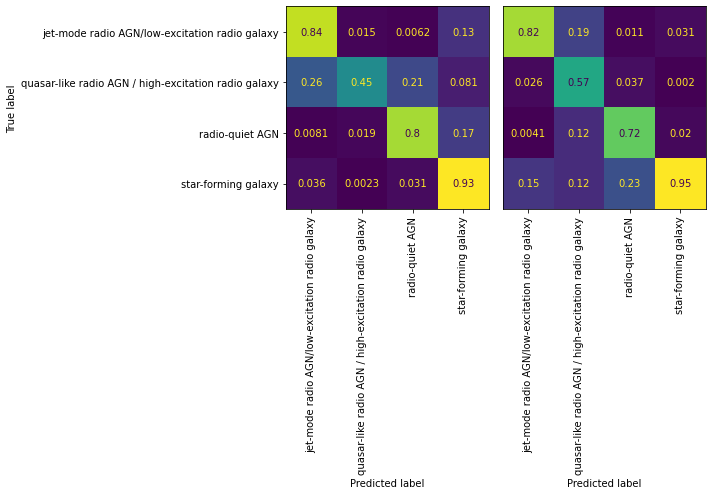

In [156]:
fig, axes = plt.subplots(1,2, figsize=(10,10))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=axes[0], colorbar=False)

cm = confusion_matrix(y_test, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=axes[1], colorbar=False)
axes[1].axes.get_yaxis().set_visible(False)
for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.tight_layout()
plt.plot()
fig.savefig("Confusion.pdf")

## Redshift dependence

In [181]:
redshifts = X.iloc[X_train['Z_BEST'].index]['Z_BEST']

<AxesSubplot:>

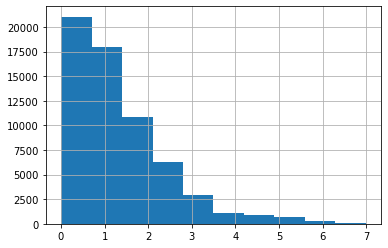

In [182]:
redshifts.hist()

In [43]:
accuracy_for_z_larger = []
accuracy_for_z_larger_std = []
z_range = [0,1,2,3,4]
for z in z_range:
    cv_score = cross_val_score(cross_val_model, X_train[redshifts>z], y_train[redshifts>z], cv=8, n_jobs=-1, scoring="accuracy")
    
    accuracy_for_z_larger.append(np.mean(cv_score))
    accuracy_for_z_larger_std.append(np.std(cv_score))

<ErrorbarContainer object of 3 artists>

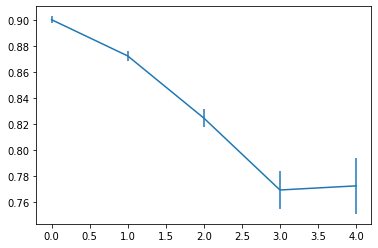

In [44]:
plt.errorbar(z_range, accuracy_for_z_larger, yerr=accuracy_for_z_larger_std)

In [183]:
accuracy_for_z_inbetween = []
accuracy_for_z_inbetween_std = []
z_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
for z in z_range:
    print(f"Working on redshift range {z}-{z+0.5}")
    filt = ((redshifts>z) & (redshifts<(z+0.5)))
    cv_score = cross_val_score(cross_val_model, X_train[filt], y_train[filt], cv=8, n_jobs=-1, scoring="accuracy")
    
    accuracy_for_z_inbetween.append(np.mean(cv_score))
    accuracy_for_z_inbetween_std.append(np.std(cv_score))

Working on redshift range 0-0.5
Working on redshift range 0.5-1.0
Working on redshift range 1-1.5
Working on redshift range 1.5-2.0
Working on redshift range 2-2.5
Working on redshift range 2.5-3.0
Working on redshift range 3-3.5
Working on redshift range 3.5-4.0
Working on redshift range 4-4.5
Working on redshift range 4.5-5.0
Working on redshift range 5-5.5


In [194]:
counts = []
z_range_counts = np.linspace(0,5,100)
for z in z_range_counts:
    filt = ((redshifts>z) & (redshifts<(z+0.5)))
    counts.append(len(X_train[filt]))

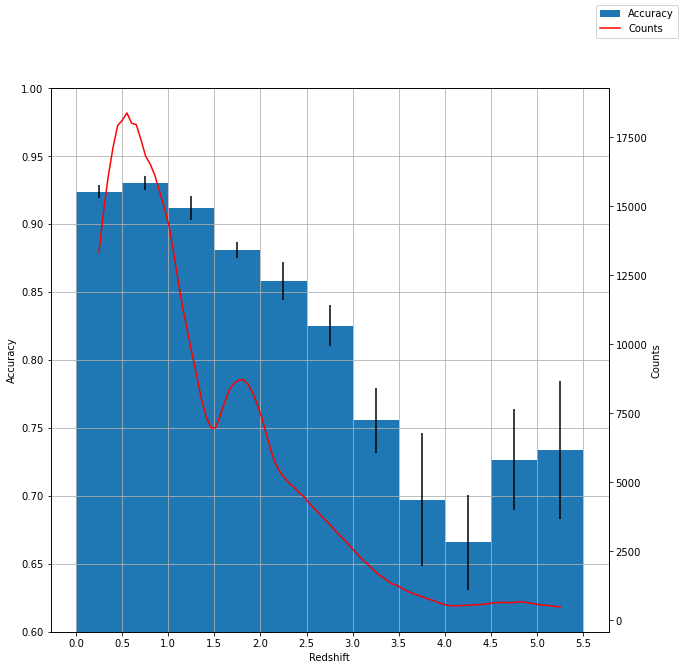

In [210]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(z_range, accuracy_for_z_inbetween, yerr=accuracy_for_z_inbetween_std, width=0.5, label='Accuracy')
ax.set_ylim(0.6,1)


ax.set_xticks(np.arange(-0.25,5.5,0.5))
ax.set_xticklabels(np.arange(0, 6, 0.5))
ax.grid()
ax.set_xlabel("Redshift")
ax.set_ylabel("Accuracy")


ax2=ax.twinx()
ax2.plot(z_range_counts, counts, c='r', label='Counts')
ax2.set_ylabel("Counts")
fig.legend()
plt.show()
fig.savefig("Redshifts.pdf")

In [76]:
accuracy_for_z_plus_1 = []
z_range = np.linspace(0,6,100)
for z in z_range:
    y_pred = model.predict(X_test[(redshifts_test>z) & (redshifts_test<(z+1))])
    accuracy_for_z_plus_1.append(accuracy_score(y_test[((redshifts_test>z) & (redshifts_test<(z+1)))], y_pred))

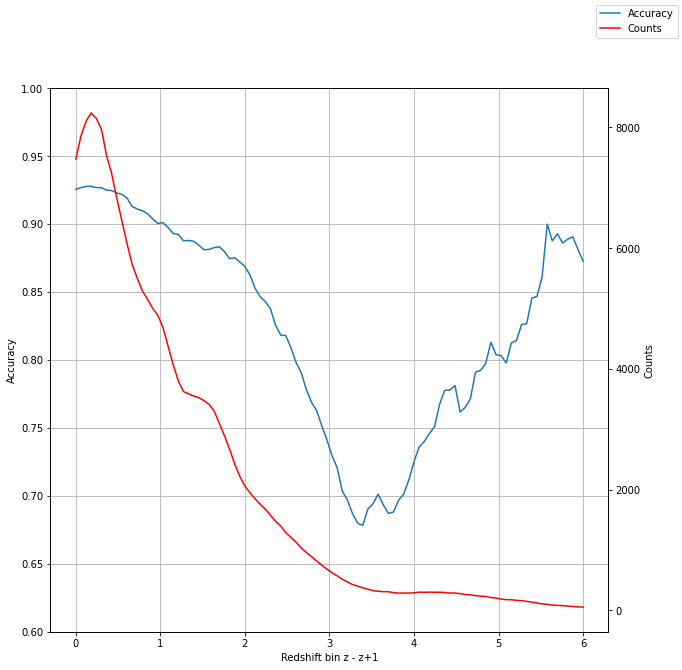

In [98]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(z_range, accuracy_for_z_plus_1, label='Accuracy')
ax.grid()
ax.set_xlabel("Redshift bin z - z+1")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.6,1)

ax2=ax.twinx()
ax2.plot(z_range, counts, c='r', label='Counts')
ax2.set_ylabel("Counts")
#ax2.xscale('log')
fig.legend()

## Feature relevance

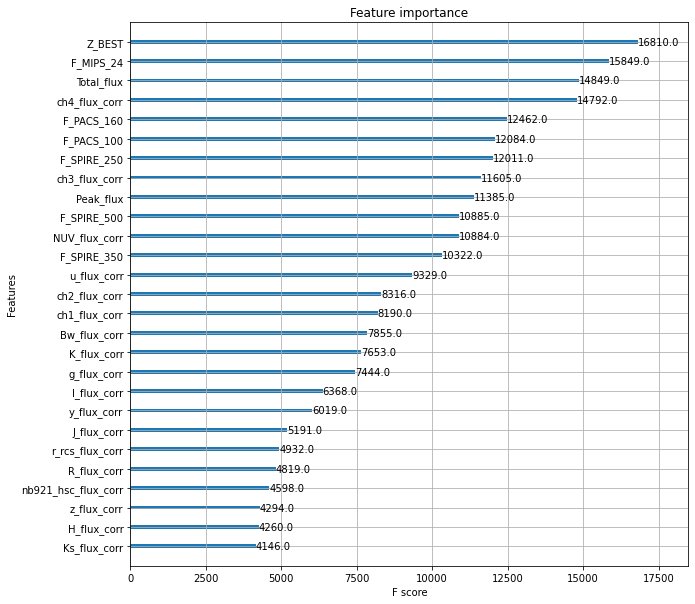

In [158]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)
fig.savefig("Feature_importance.pdf")

## Flag marking

In [215]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=['Prediction'])

In [216]:
Xray_all = []
opt_spec_all = []
ext_radio_all = []
IR_all = []
for j in range(4):
    for i in range(4):
        # Finding pandas dataframes for the squares in the confusion matrix
        cm_square = y_pred[(y_test['Classification']==j) & (y_pred['Prediction']==i)]
        flags = y_test_flags.loc[cm_square.index]

        # Finding frequencies of flags
        Xray_freq = sum(flags['Xray'])/len(flags['Xray'])
        opt_spec_freq = sum(flags['Opt_spec'])/len(flags['Opt_spec'])
        ext_radio_freq = sum(flags['Extended_radio'])/len(flags['Extended_radio'])
        IR_freq = sum(flags['IRAGN'])/len(flags['IRAGN'])

        Xray_all.append(Xray_freq)
        opt_spec_all.append(opt_spec_freq)
        ext_radio_all.append(ext_radio_freq)
        IR_all.append(IR_freq)

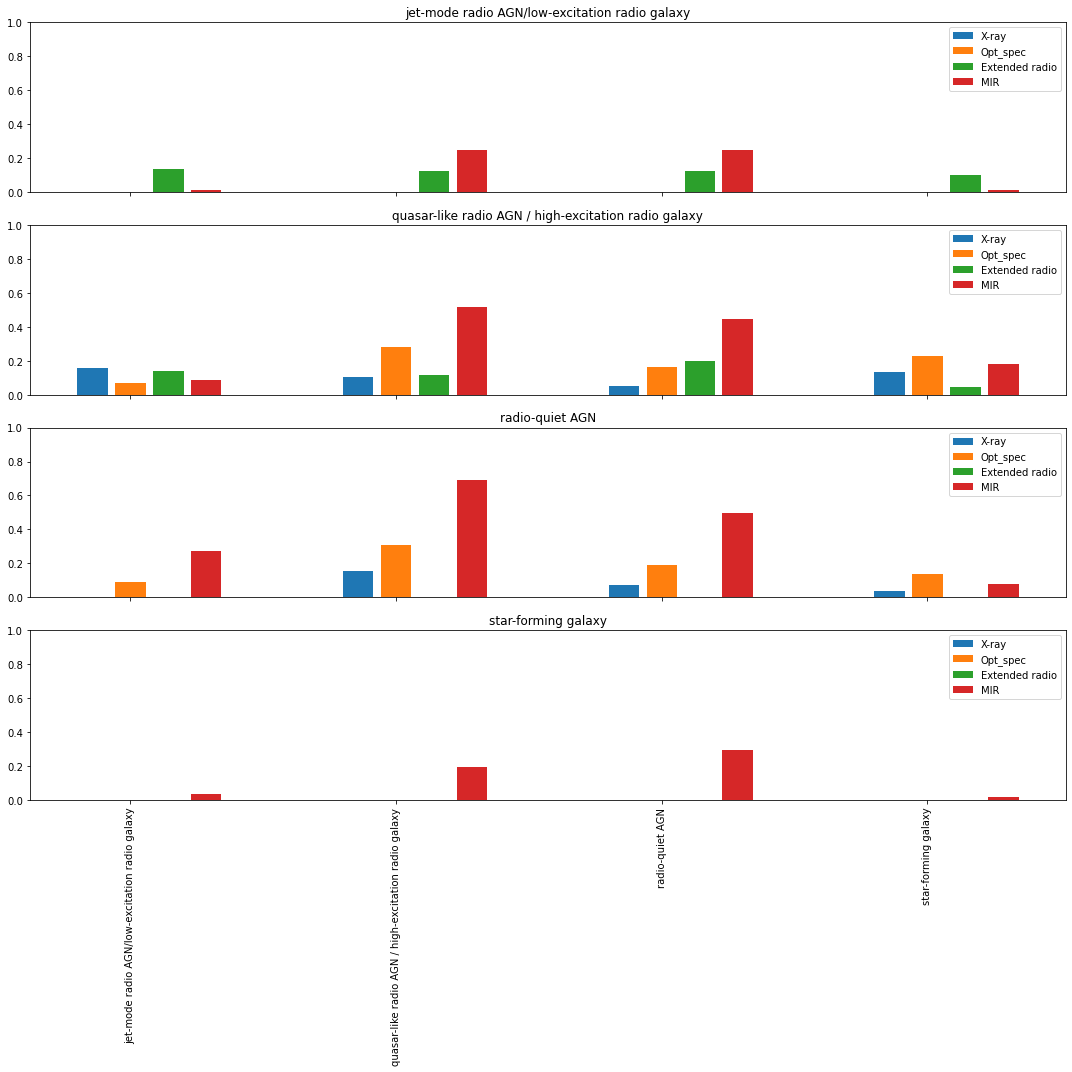

In [217]:
x = np.arange(0,26,7)
fig, axes = plt.subplots(4, 1, figsize=(15,15), sharex='all')
for i, ax in enumerate(axes):
    i0 = i*4
    i1 = (i+1)*4
    
    ax.bar(x, Xray_all[i0:i1], label='X-ray')
    # For setting the tick labels
    ax.bar(x+1, opt_spec_all[i0:i1], label='Opt_spec', tick_label=labels)
    ax.bar(x+2, ext_radio_all[i0:i1], label='Extended radio')
    ax.bar(x+3, IR_all[i0:i1], label='MIR')
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_title(f'{labels[i]}')
    ax.set_ylim(0,1)
    ax.legend()
plt.tight_layout()
fig.savefig('Flags.pdf')

# Adaboost

In [197]:
from sklearn.ensemble import AdaBoostClassifier

In [207]:
ada = AdaBoostClassifier(n_estimators=50, learning_rate=0.3, random_state=42)

In [208]:
ada.fit(X_train, y_train, sample_weight=classes_weights)

AdaBoostClassifier(learning_rate=0.3, random_state=42)

In [209]:
y_pred = ada.predict(X_train)
print(classification_report(y_train, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.4535    0.5478    0.4962     10186
quasar-like radio AGN / high-excitation radio galaxy     0.1239    0.4896    0.1978      1062
                                     radio-quiet AGN     0.4399    0.6761    0.5330      5514
                                 star-forming galaxy     0.8776    0.7186    0.7902     45325

                                            accuracy                         0.6829     62087
                                           macro avg     0.4738    0.6080    0.5043     62087
                                        weighted avg     0.7563    0.6829    0.7090     62087



In [210]:
y_pred = ada.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.4391    0.5339    0.4819      2581
quasar-like radio AGN / high-excitation radio galaxy     0.1155    0.4667    0.1852       270
                                     radio-quiet AGN     0.4225    0.6652    0.5168      1356
                                 star-forming galaxy     0.8730    0.7066    0.7810     11315

                                            accuracy                         0.6701     15522
                                           macro avg     0.4625    0.5931    0.4912     15522
                                        weighted avg     0.7483    0.6701    0.6978     15522



# DNN

In [28]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dic = {i:class_weight[i] for i in range(4)}

In [70]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4),
    ]
)

In [71]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="Adam",
    metrics=["accuracy"],
)

In [72]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
)

In [74]:
model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=1000,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),
    class_weight=class_weight_dic,
)

Epoch 1/1000
1941/1941 [==============================] - 5s 2ms/step - loss: 1.2237 - accuracy: 0.5100 - val_loss: 1.1177 - val_accuracy: 0.6102
Epoch 2/1000
1941/1941 [==============================] - 5s 2ms/step - loss: 1.1852 - accuracy: 0.5153 - val_loss: 1.1890 - val_accuracy: 0.2875
Epoch 3/1000
1047/1941 [===============>..............] - ETA: 2s - loss: 1.1610 - accuracy: 0.5283

KeyboardInterrupt: 

# SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = SVC(class_weight='balanced')
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# temp

In [23]:
from sklearn.gaussian_process import GaussianProcessClassifier

In [24]:
gpc = GaussianProcessClassifier(random_state=0).fit(X_train, y_train)

d:\python\python38\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MemoryError: Unable to allocate 14.4 GiB for an array with shape (1927366741,) and data type float64

In [ ]:
y_pred = gpc.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

In [37]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, max_depth=8).fit(X_train, y_train)

In [38]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7918    0.3905    0.5231      2581
           1     0.4298    0.1815    0.2552       270
           2     0.6592    0.3481    0.4556      1356
           3     0.8138    0.9651    0.8830     11315

    accuracy                         0.8020     15522
   macro avg     0.6737    0.4713    0.5292     15522
weighted avg     0.7899    0.8020    0.7749     15522

